In [1]:
import os
import numpy as np
import torch
import pydicom
import matplotlib.pyplot as plt
from tcia_utils import nbia
from monai.bundle import ConfigParser, download
from monai.transforms import LoadImage, LoadImaged, Orientation, Orientationd, EnsureChannelFirst, EnsureChannelFirstd, Compose
from rt_utils import RTStructBuilder
from scipy.ndimage import label, measurements
import json

2024-06-03 23:24:56.665044: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 23:24:56.665102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 23:24:56.718757: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 23:24:56.843558: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 23:24:58.240658: W tensorflow/compiler/tf2

In [2]:
datadir = '/home/shankar/code/data/'

#### Open CT Image

In [3]:
cart_name = "nbia-90531717429201301"
cart_data = nbia.getSharedCart(cart_name)
df = nbia.downloadSeries(cart_data, format="df", path = datadir)

2024-06-03 23:25:01,999:INFO:Calling... https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName with parameters {'name': 'nbia-90531717429201301'}
2024-06-03 23:25:03,246:INFO:Downloading 1 Series Instance UIDs (scans).
2024-06-03 23:25:04,486:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668 already downloaded.
2024-06-03 23:25:04,487:INFO:Downloaded 0 out of 1 Series Instance UIDs (scans).
0 failed to download.
1 previously downloaded.


In [4]:
CT_folder = os.path.join(datadir, '1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668')

#### Using `pydicom`

In [5]:
ds = pydicom.read_file(os.path.join(CT_folder, '1-394.dcm'))

We can obtain pixel data by accessing the `pixel_array` attribute

In [6]:
image = ds.pixel_array
image.shape

(512, 512)

Note that the image is a 2D array. Typically the pixel values are stored in a scaled format so we should adjust them:

In [11]:
image = ds.RescaleSlope * image + ds.RescaleIntercept

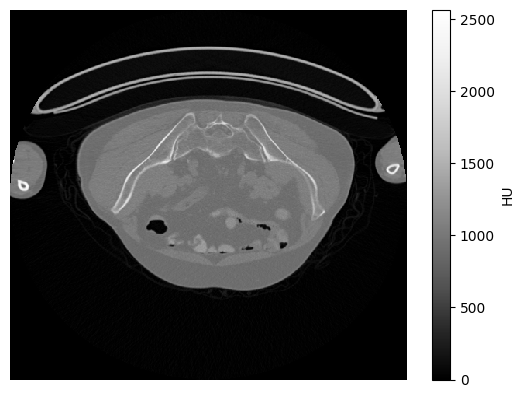

In [7]:
plt.pcolormesh(image, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

#### Using `monai`

In [9]:
image_loader = LoadImage(image_only=True)
CT = image_loader(CT_folder)

/home/shankar/.local/lib/python3.10/site-packages/monai/transforms/io/array.py:255: UserWarning: Failed to read /home/shankar/code/data/1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668/LICENSE with exception: 
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading..
  img = reader.read(filename)


The CT contains both the pixel data (for all slices) and the image metadata

In [10]:
CT.meta

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '00200032': {'vr': 'DS', 'Value': [-249.51171875, -401.01171875, 1937.0]},
 '00280030': {'vr': 'DS', 'Value': [0.9765625, 0.9765625, 2.0]},
 'spacing': array([0.9765625, 0.9765625, 2.       ]),
 'lastImagePositionPatient': array([-249.51171875, -401.01171875,  -11.        ]),
 spatial_shape: (512, 512, 975),
 space: RAS,
 original_affine: array([[-9.76562500e-01,  0.00000000e+00,  0.00000000e+00,
          2.49511719e+02],
        [ 0.00000000e+00, -9.76562500e-01,  0.00000000e+00,
          4.01011719e+02],
        [ 0.00000000e+00,  0.00000000e+00, -2.00000000e+00,
          1.93700000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 affine: tensor([[-9.7656e-01,  0.0000e+00,  0.0000e+00,  2.4951e+02],
         [ 0.0000e+00, -9.7656e-01,  0.0000e+00,  4.0101e+02],
         [ 0.0000e+00,  0.0000e+00, -2.0000e+00,  1.9370e+03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e

Now we can plot any plane of the CT image we like

In [11]:
CT_coronal_slice = CT[:,256].cpu().numpy()

View CT image

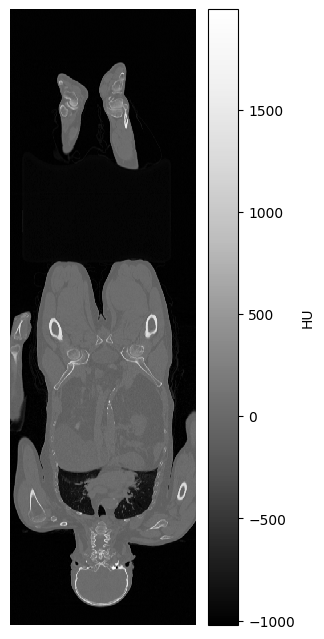

In [12]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

Notice that he's upside-down! We can manually reverse the axis, or we can use MONAI functionality to modify the CT. Firstly we add a channel dimension, since this is required for most AI applications

In [13]:
CT.shape

torch.Size([512, 512, 975])

In [14]:
channel_transform = EnsureChannelFirst()
CT = channel_transform(CT)
CT.shape

torch.Size([1, 512, 512, 975])

Alternatively, we can combine all these transforms in one go when we open the image data:

In [15]:
preprocessing_pipeline = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Orientation(axcodes='LPS')
])

And we can open using this preprocessing pipeline:

In [16]:
CT = preprocessing_pipeline(CT_folder)
CT_coronal_slice = CT[0,:,256].cpu().numpy()

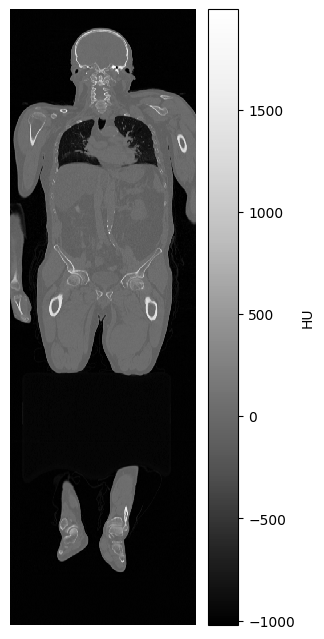

In [17]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

One other option (which is typically done) is to use the "dictionary" version of all the transforms above. This is done by adding a `d` to the end of the transforms, such as `LoadImaged`.
* These transforms take in a dictionary with keys-value pairs

In [18]:
data = {'image': CT_folder, 'key': 42}

In [19]:
preprocessing_pipeline = Compose([
    LoadImaged(keys='image', image_only=True),
    EnsureChannelFirstd(keys='image'),
    Orientationd(keys='image',axcodes='LPS')
])

In [20]:
data = preprocessing_pipeline(data)

In [21]:
data

{'image': metatensor([[[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           

#### Segmentation Model from `MONAI`

In [22]:
model_name = "wholeBody_ct_segmentation"
download(name=model_name, bundle_dir=datadir)

2024-06-03 23:26:18,642 - INFO - --- input summary of monai.bundle.scripts.download ---
2024-06-03 23:26:18,643 - INFO - > name: 'wholeBody_ct_segmentation'
2024-06-03 23:26:18,644 - INFO - > bundle_dir: '/home/shankar/code/data/'
2024-06-03 23:26:18,646 - INFO - > source: 'monaihosting'
2024-06-03 23:26:18,646 - INFO - > remove_prefix: 'monai_'
2024-06-03 23:26:18,646 - INFO - > progress: True
2024-06-03 23:26:18,647 - INFO - ---




wholeBody_ct_segmentation_v0.2.4.zip: 133MB [00:08, 15.7MB/s]                              


2024-06-03 23:26:28,526 - INFO - Downloaded: /home/shankar/code/data/wholeBody_ct_segmentation_v0.2.4.zip
2024-06-03 23:26:28,527 - INFO - Expected md5 is None, skip md5 check for file /home/shankar/code/data/wholeBody_ct_segmentation_v0.2.4.zip.
2024-06-03 23:26:28,528 - INFO - Writing into directory: /home/shankar/code/data.


In [24]:
model_path = os.path.join(datadir, 'wholeBody_ct_segmentation', 'models', 'model_lowres.pt')
config_path = os.path.join(datadir, 'wholeBody_ct_segmentation', 'configs', 'inference.json')

In [25]:
config = ConfigParser()
config.read_config(config_path)

## Preprocessing Pipeline

From this we can extract the preprocessing pipeline specified by the `inference.json` file
* These are all the operations applied to the data before feeding it to the model

In [26]:
preprocessing = config.get_parsed_content("preprocessing")

Note that this preprocessing pipeline uses `LoadImaged` instead of `LoadImage`. The `d` at the end refers to the fact that everything should be fed in as a dictionary. The `keys` argument are the keys of the dictionary by which to apply the transform to

In [27]:
data = preprocessing({'image': CT_folder})

In this case, the operations have only been applied to things with the key `'image'`. We could add extra keys and nothing would happen.

## Model

Now we can obtain the model using the `'network'` key from the json file

In [28]:
model = config.get_parsed_content("network")

In [29]:
model.eval();

#### Inferer

The `"inferer"` pipeline takes in the data and the model, and returns model output. It contains some extra processing steps (in this case it breaks the data into 96x96x96 chunks before feeding it into the model)

In [30]:
inferer = config.get_parsed_content("inferer")

#### Postprocessing

In [31]:
postprocessing = config.get_parsed_content("postprocessing")

In [32]:
data['image'].unsqueeze(0).shape

torch.Size([1, 1, 167, 167, 650])

#### Prediction Time :)

##### i tried running this below cell (prepocessing)  but it is taking too long to run and it crashed my computer due to lack of computational power. So i am skipping this part for now.

In [ ]:
data = preprocessing({'image': CT_folder}) # returns a dictionary
# 2. Compute mask prediction, add it to dictionary
with torch.no_grad():
    # Have to add additional batch dimension to feed into model
    data['pred'] = inferer(data['image'].unsqueeze(0), network=model)
# Remove batch dimension in image and prediction
data['pred'] = data['pred'][0]
data['image'] = data['image'][0]
# Apply postprocessing to data
data = postprocessing(data)
segmentation = torch.flip(data['pred'][0], dims=[2])
segmentation = segmentation.cpu().numpy()

In [35]:
slice_idx = 250
CT_coronal_slice = CT[0,:,slice_idx].cpu().numpy()
segmentation_coronal_slice = segmentation[:,slice_idx]

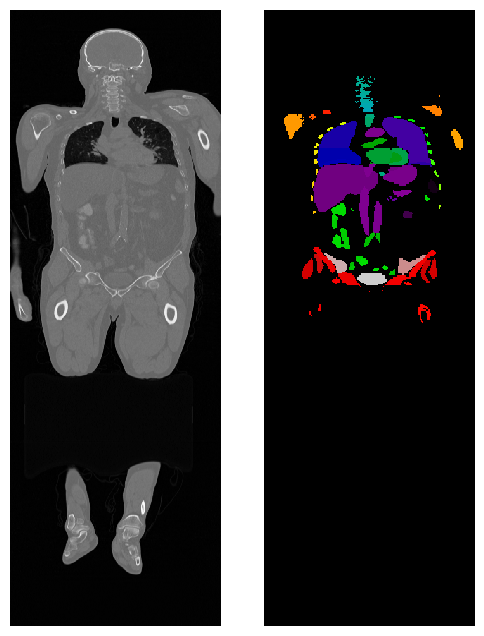

In [37]:
plt.subplots(1,2,figsize=(6,8))
plt.subplot(121)
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(segmentation_coronal_slice.T, cmap='nipy_spectral')
plt.axis('off')
plt.show()